### Code to demo the REINFORCE model

Last updated 3/21/2025

---

References

- https://pytorch.org/docs/stable/distributions.html
- Draft code sourced from ChatGPT
  - Needed to make edits for things to run:
    1.
      import gym  
      to  
      import gymnasium as gym

    2.  
      state = env.reset()  
      to  
      state = env.reset()[0]

    3.  next_state, reward, done, _ = env.step(action)       
        to  
        next_state, reward, terminated, truncated, _ = env.step(action)  
        done = terminated or truncated

---

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import gymnasium as gym
import matplotlib.pyplot as plt

In [8]:

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        action_probs = F.softmax(self.fc2(x), dim=-1)
        return action_probs

class REINFORCE:
    def __init__(self, state_dim, action_dim, learning_rate=0.01):
        self.policy_network = PolicyNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=learning_rate)
        self.log_probs = []
        self.rewards = []
        self.losses = []

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        action_probs = self.policy_network(state)
        action_dist = torch.distributions.Categorical(action_probs)
        action = action_dist.sample()
        self.log_probs.append(action_dist.log_prob(action))
        return action.item()

    def store_reward(self, reward):
        self.rewards.append(reward)

    def update_policy(self, gamma=0.99):
        discounted_rewards = []
        R = 0
        for r in reversed(self.rewards):
            R = r + gamma * R
            discounted_rewards.insert(0, R)
        discounted_rewards = torch.tensor(discounted_rewards)

        # normalize rewards
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)

        # minimize negative grad log_prob x gain.
        # negative because optimizers use gradient descent but we want gradient ascent
        loss = 0
        for log_prob, reward in zip(self.log_probs, discounted_rewards):
            loss -= log_prob * reward

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.losses.append(loss.item())


        self.log_probs = []
        self.rewards = []

    def plot_losses(self):
        plt.plot(self.losses)
        plt.xlabel("Episodes")
        plt.ylabel("Loss")
        plt.title("REINFORCE Loss Over Time")
        plt.show()

Episode 1/500, Reward: 11.0
Episode 11/500, Reward: 13.0
Episode 21/500, Reward: 163.0
Episode 31/500, Reward: 55.0
Episode 41/500, Reward: 39.0
Episode 51/500, Reward: 64.0
Episode 61/500, Reward: 162.0
Episode 71/500, Reward: 258.0
Episode 81/500, Reward: 87.0
Episode 91/500, Reward: 51.0
Episode 101/500, Reward: 54.0
Episode 111/500, Reward: 49.0
Episode 121/500, Reward: 102.0
Episode 131/500, Reward: 500.0
Episode 141/500, Reward: 282.0
Episode 151/500, Reward: 158.0
Episode 161/500, Reward: 108.0
Episode 171/500, Reward: 148.0
Episode 181/500, Reward: 126.0
Episode 191/500, Reward: 128.0
Episode 201/500, Reward: 316.0
Episode 211/500, Reward: 300.0
Episode 221/500, Reward: 320.0
Episode 231/500, Reward: 243.0
Episode 241/500, Reward: 500.0
Episode 251/500, Reward: 289.0
Episode 261/500, Reward: 280.0
Episode 271/500, Reward: 396.0
Episode 281/500, Reward: 162.0
Episode 291/500, Reward: 282.0
Episode 301/500, Reward: 500.0
Episode 311/500, Reward: 489.0
Episode 321/500, Reward: 310

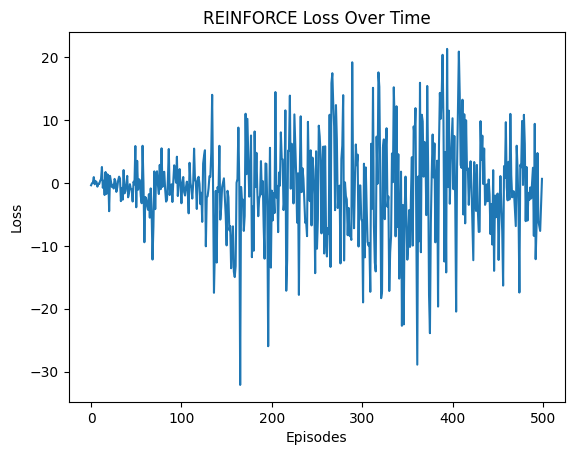

In [9]:
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = REINFORCE(state_dim, action_dim)
episodes = 500
for episode in range(episodes):
    state = env.reset()[0]
    episode_reward = 0
    done = False

    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        agent.store_reward(reward)
        episode_reward += reward
        state = next_state

    agent.update_policy()
    if episode % 10 == 0:
        print(f"Episode {episode + 1}/{episodes}, Reward: {episode_reward}")

agent.plot_losses()
env.close()


Notice that

- Episode rewards are not consistently high after 300 episodes
- The loss function doesn't converge

In the next notebook, we will include a baseline for improved stability.